In [1]:
import numpy as np
import matplotlib.pyplot as plt

[7.825772532124727, 8.879776258266325, 9.397818977364997]


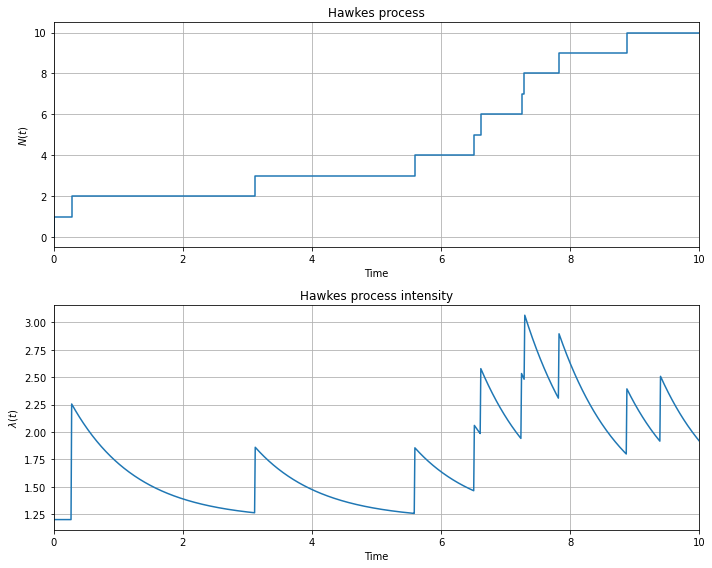

In [268]:
class HawkesProcess:
    def __init__(self, mu, alpha, beta, T):
        if alpha <  0 or beta < alpha:
            raise ValueError(f"We must have 0 < alpha < beta (alpha={alpha} and beta={beta})")
        self.mu = mu
        self.alpha = alpha
        self.beta = beta
        self.T = T
        self.events = self.generate_events()
        self.N = len(self.events)

    def lamb(self, t, tau):
        return self.mu + sum([self.alpha * np.exp(-self.beta*(t-tk)) for tk in tau])

    def generate_events(self):
        Tau = []
        s = n = 0
        while s < self.T:
            lambda_bar = self.lamb(s, Tau)
            u = np.random.uniform(0,1)
            w = -np.log(u)/lambda_bar
            s += w
            D = np.random.uniform(0,1)
            if D*lambda_bar <= self.lamb(s, Tau):
                n += 1
                t = s
                Tau.append(t)
        if t <= self.T:
            return Tau
        else:
            return Tau[:-1]

    def _generate_intensity(self, res=1000):
        x = np.linspace(0, self.T, res)
        intensity = self.mu * np.ones(res)
        points0 = self._events_with_limits()
        for i in range(len(points0)-1):
            p1, p2 = points0[i:i+2]
            i1 = (np.abs(x - p1)).argmin()
            i2 = (np.abs(x - p2)).argmin()
            if i == 0:
                intensity[i1:i2+1] = self.mu
            else:
                local_intensity = np.array([self.lamb(x[ii], points0[:i+1]) for ii in range(i1, i2+1)])
                intensity[i1:i2+1] = local_intensity
        return x, intensity

    def _events_with_limits(self):
        return [0] + self.events + [self.T]

    def plot_process(self, width=10, height=6):
        plt.figure(figsize=(width, height))
        plt.step([0] + self.events, range(self.N+1), where="pre")
        plt.title("Hawkes process")
        plt.xlim(0, self.T)
        plt.grid()
        plt.show()

    def plot_intensity(self, width=10, height=6):
        plt.figure(figsize=(width, height))
        absintens, intens = self._generate_intensity()
        plt.plot(absintens, intens)
        plt.title("Hawkes process intensity")
        plt.xlim(0, self.T)
        plt.grid()
        plt.show()

    def plot_process_and_intensity(self, width=10, height=8):
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(width, height))
        ax1.step(self._events_with_limits(), list(range(self.N+1))+[self.N], where="pre")
        ax1.set_xlim(0, self.T)
        ax1.grid()
        ax1.set_title("Hawkes process")
        ax1.set_xlabel("Time")
        ax1.set_ylabel("$N(t)$")
        absintens, intens = self._generate_intensity()
        ax2.plot(absintens, intens)
        ax2.set_xlim(0, self.T)
        ax2.grid()
        ax2.set_title("Hawkes process intensity")
        ax2.set_xlabel("Time")
        ax2.set_ylabel("$\lambda(t)$")
        fig.tight_layout()
        plt.show()

h = HawkesProcess(1.2, 0.6, 1, 10)
print(h.events[-3:])
h.plot_process_and_intensity()

In [254]:
list(range(10)).append([1])

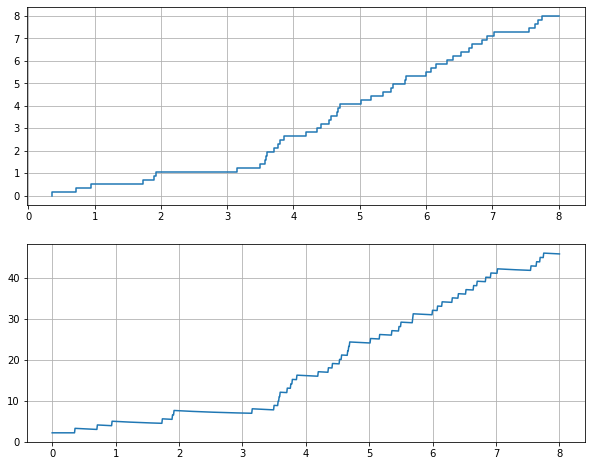

In [18]:
h = HawkesProcess(1.2, 0.6, 0.8, 8)
h.plot_process_and_intensity()

In [8]:
def lamb(s, mu, alpha, beta, Tau):
    return mu + sum([alpha * np.exp(-beta*(s-tau)) for tau in Tau])

def generate_hawkes_process(mu, alpha, beta, T):
    if alpha <  0 or beta < alpha:
        raise ValueError(f"We must have 0 < alpha < beta (alpha={alpha} and beta={beta})")
    Tau = []
    s = n = 0
    while s < T:
        lambda_bar = lamb(s, mu, alpha, beta, Tau)
        u = np.random.uniform(0,1)
        w = -np.log(u)/lambda_bar
        s += w
        D = np.random.uniform(0,1)
        if D*lambda_bar <= lamb(s, mu, alpha, beta, Tau):
            n += 1
            t = s
            Tau.append(t)
    if t <= T:
        return Tau
    else:
        Tau[:-1]
    return Tau

def intensity(points, mu, alpha, beta, T, res=1000):
    x = np.linspace(0, T, res)
    intensity = mu * np.ones(res)
    points0 = np.append(0, points)
    # print(points0)
    for i in range(len(points0)-1):
        p1, p2 = points0[i:i+2]
        # print(p1, p2)
        i1 = (np.abs(x - p1)).argmin()
        i2 = (np.abs(x - p2)).argmin()
        if i == 0:
            intensity[i1:i2+1] = mu
        else:
            local_intensity = [alpha * np.exp(-beta*(x[ii] - x[i1])) for ii in range(i1, i2+1)]
            intensity[i1:i2+1] = intensity[i1-1] + local_intensity
#         plt.plot(local_intensity)
#         plt.show()
    return x, intensity

def plot_hawkes_process(times)

mu = 1.2
alpha = 0.6
beta = 0.8
T = 8
pts = generate_hawkes_process(mu, alpha, beta, T)
print(pts)
plt.figure(figsize=(10,6))
plt.step(pts, np.linspace(0,T,len(pts)), where="pre")
plt.show()
absintens, intens = intensity(pts, mu, alpha, beta, T)
plt.plot(absintens, intens*len(pts)/max(intens))
plt.grid()
plt.show()

SyntaxError: invalid syntax (<ipython-input-8-c5232dc68cf9>, line 44)

In [61]:
range(len(pts))
print(pts)

[1.5315265169149233, 4.883622005443111, 5.638964215430252, 5.767003896349309, 7.496846824311912, 7.737181061373519, 9.209548116787456, 10.01471937568677]


In [74]:
a, b = [1,2,3,4,5][1:1+2]
print(a, b)

2 3
